In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as cp
import sys
import os
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array, median_results_array
from plotting_performance_vs_metric import get_rff_memory_with_model, get_nystrom_memory_with_model, get_cir_rff_memory_with_model
# from plotting_performance_vs_metric import get_rff_memory, get_nystrom_memory, get_cir_rff_memory
import math
from copy import deepcopy

### the data folder is called full tuning run but it is the full run after tuning round

In [2]:
def get_performance_list(n_feat_list, general_folder, folder_pattern, seeds, min_metric_best, performance_file_name, do_median):
        metric_list_all = []
        for seed in seeds:
            metric_list = []
            for n_feat in n_feat_list:
                subfolder = deepcopy(folder_pattern)
#                 subfolder = subfolder.replace("type_unk", "type_rff")
                subfolder = subfolder.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
                subfolder = subfolder.replace("seed_unk", "seed_" + str(seed) )
                folder_name = general_folder + "/" + subfolder
                file_name = performance_file_name
                metric = get_performance_metric(folder_name, file_name, min_best=min_metric_best)
                metric_list.append(metric)
            metric_list_all.append(np.array(deepcopy(metric_list) ) )
        if do_median:
            metric_list_all = median_results_array(metric_list_all)
        else:
            metric_list_all = average_results_array(metric_list_all)
        return metric_list_all

In [3]:
def get_metric_list(n_feat_list, general_folder, folder_pattern, seeds, min_metric_best, metric_file_name, metric_name, do_median):
        metric_list_all = []
        for seed in seeds:
            metric_list = []
            for n_feat in n_feat_list:
                subfolder = deepcopy(folder_pattern)
#                 subfolder = subfolder.replace("type_unk", "type_rff")
                subfolder = subfolder.replace("n_fp_feat_unk", "n_fp_feat_" + str(n_feat) )
                subfolder = subfolder.replace("seed_unk", "seed_" + str(seed) )
                folder_name = general_folder + "/" + subfolder
                file_name = metric_file_name
                metric = get_measurement_metric(folder_name, file_name, metric_name)
                metric_list.append(metric)
            metric_list_all.append(np.array(deepcopy(metric_list) ) )
        if do_median:
            metric_list_all = median_results_array(metric_list_all)
        else:
            metric_list_all = average_results_array(metric_list_all)
        return metric_list_all

In [4]:
def get_mem_saving(baseline_perf, baseline_mem, lp_perf, lp_mem, threshold=0.001, min_best=True):
    lp_mem_saving = []
    for key in lp_perf.keys():
        if min_best:
            idx = np.argmax(lp_perf[key] <= baseline_perf * (1.0 + threshold) )
            if np.sum(lp_perf[key] <= baseline_perf * (1.0 + threshold) ) == 0:
                idx = -1
        else:
            idx = np.argmax(lp_perf[key] >= baseline_perf * (1.0 - threshold) )
            if np.sum(lp_perf[key] >= baseline_perf * (1.0 - threshold) ) == 0:
                idx = -1
        print "baseline / lp ", idx, baseline_mem, lp_mem[key][idx], baseline_perf, lp_perf[key][idx]
        if idx == -1:
            lp_mem_saving.append(-1)
        else:
            lp_mem_saving.append(baseline_mem /float(lp_mem[key][idx] ) )
    print "lp memory saving ", np.max(lp_mem_saving)
    return np.max(lp_mem_saving)

In [5]:
def plot_full_run(n_rff_feat, n_nystrom_feat, general_folder_performance, general_folder_metric, folder_pattern, seeds=[1,], 
                  rff_mem_func=None, nystrom_mem_func=None, cir_rff_mem_func=None, min_metric_best=True, 
                  performance_file_name="eval_metric.txt", 
                  metric_file_name="metric_sample_eval.txt", do_median=False, 
                  do_logx_plot=False, do_logy_plot=False, ylim=None, performance_name="L2 loss", mem_saving_thresh=0.001):
    memory_list_rff = np.array( [rff_mem_func(n_feat) for n_feat in n_rff_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_rff")
    performance_list_rff = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, min_metric_best, performance_file_name, do_median)
#     metric_list_rff = get_metric_list(n_rff_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
    
    memory_list_nystrom = np.array( [nystrom_mem_func(n_feat) for n_feat in n_nystrom_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_nystrom")
    performance_list_nystrom = get_performance_list(n_nystrom_feat, general_folder_performance, subfolder_pattern, seeds, min_metric_best, performance_file_name, do_median)
#     metric_list_nystrom = get_metric_list(n_nystrom_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
    
    memory_list_cir_rff = np.array( [cir_rff_mem_func(n_feat, 64) for n_feat in n_rff_feat] )
    subfolder_pattern = folder_pattern.replace("type_unk", "type_cir_rff")
    subfolder_pattern =  subfolder_pattern.split("_seed_unk")[0] + "_nbit_" + str(64) + "_seed_unk"
    general_folder_performance = deepcopy(general_folder_performance).replace("nystrom_vs_rff_large_exp/full_tuning_run", "lp_rff/full_run")
    performance_list_cir_rff = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, min_metric_best, performance_file_name, do_median)
#     metric_list_cir_rff = get_metric_list(n_rff_feat, general_folder_metric, subfolder_pattern, seeds, min_metric_best, metric_file_name, metric_name=None, do_median=do_median)
    
    nbit_list = [16, 8, 4, 2, 1]
    lp_cir_rff_perf_dict = {}
    lp_cir_rff_memory_dict = {}
    for nbit in nbit_list:
        memory_list_cir_rff_lp = np.array( [cir_rff_mem_func(n_feat, nbit) for n_feat in n_rff_feat] )
        subfolder_pattern = folder_pattern.replace("type_unk", "type_cir_rff")
        subfolder_pattern =  subfolder_pattern.split("_seed_unk")[0] + "_nbit_" + str(nbit) + "_seed_unk"
        general_folder_performance = deepcopy(general_folder_performance).replace("nystrom_vs_rff_large_exp/full_tuning_run", "lp_rff/full_run")
        performance_list_cir_rff_lp = get_performance_list(n_rff_feat, general_folder_performance, subfolder_pattern, seeds, min_metric_best, performance_file_name, do_median)
        lp_cir_rff_perf_dict[nbit] = performance_list_cir_rff_lp
        lp_cir_rff_memory_dict[nbit] = deepcopy(memory_list_cir_rff_lp)
    
    dataset_name = folder_pattern.split("_")[0]
    plt.figure()
    plt.plot(n_rff_feat, np.array(performance_list_rff).astype(np.float64), "-o", label="fp rff")
    plt.plot(n_rff_feat, np.array(performance_list_cir_rff).astype(np.float64), "-o", label="fp cir rff")
    print 64, performance_list_cir_rff
    for nbit in nbit_list:
        plt.plot(n_rff_feat, lp_cir_rff_perf_dict[nbit], "-o", label="lp cir rff " + str(nbit) + " bits" )
        print nbit, lp_cir_rff_perf_dict[nbit]
    plt.plot(n_nystrom_feat, np.array(performance_list_nystrom).astype(np.float64), "-o", label="fp nystrom")
#     plt.title("metric vs n feat")
    plt.xlabel("# feat")
    plt.ylabel("Heldout " + performance_name)
    plt.legend()
    if do_logy_plot:
        plt.yscale("log")
    if do_logx_plot:
        plt.xscale("log")
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid()
    plt.tight_layout()
    plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_feat.pdf")
    plt.show()
    
    
    # calculate memroy saving
    if min_metric_best:
        print "comparing to fp rff", performance_list_rff, memory_list_rff
        get_mem_saving(baseline_perf=np.min(performance_list_rff), 
                             baseline_mem=memory_list_rff[np.argmin(performance_list_rff)], 
                             lp_perf=lp_cir_rff_perf_dict, lp_mem=lp_cir_rff_memory_dict, 
                             threshold=mem_saving_thresh, min_best=min_metric_best)
        print "comparing to cir fp rff"
        get_mem_saving(baseline_perf=np.min(performance_list_cir_rff), 
                             baseline_mem=memory_list_cir_rff[np.argmin(performance_list_cir_rff)], 
                             lp_perf=lp_cir_rff_perf_dict, lp_mem=lp_cir_rff_memory_dict, 
                             threshold=mem_saving_thresh, min_best=min_metric_best)
        print "comparing to nystrom"
        get_mem_saving(baseline_perf=np.min(performance_list_nystrom), 
                             baseline_mem=memory_list_nystrom[np.argmin(performance_list_nystrom)], 
                             lp_perf=lp_cir_rff_perf_dict, lp_mem=lp_cir_rff_memory_dict, 
                             threshold=mem_saving_thresh, min_best=min_metric_best)
    else:
        print "comparing to fp rff", performance_list_rff, memory_list_rff
        get_mem_saving(baseline_perf=np.max(performance_list_rff), 
                             baseline_mem=memory_list_rff[np.argmax(performance_list_rff)], 
                             lp_perf=lp_cir_rff_perf_dict, lp_mem=lp_cir_rff_memory_dict, 
                             threshold=mem_saving_thresh, min_best=min_metric_best)
        print "comparing to cir fp rff"
        get_mem_saving(baseline_perf=np.max(performance_list_cir_rff), 
                             baseline_mem=memory_list_cir_rff[np.argmax(performance_list_cir_rff)], 
                             lp_perf=lp_cir_rff_perf_dict, lp_mem=lp_cir_rff_memory_dict, 
                             threshold=mem_saving_thresh, min_best=min_metric_best)
        print "comparing to nystrom"
        get_mem_saving(baseline_perf=np.max(performance_list_nystrom), 
                             baseline_mem=memory_list_nystrom[np.argmax(performance_list_nystrom)], 
                             lp_perf=lp_cir_rff_perf_dict, lp_mem=lp_cir_rff_memory_dict, 
                             threshold=mem_saving_thresh, min_best=min_metric_best)
            
    plt.figure()
    plt.plot(memory_list_rff, np.array(performance_list_rff).astype(np.float64), "-o", label="fp rff")
    plt.plot(memory_list_cir_rff, np.array(performance_list_cir_rff).astype(np.float64), "-o", label="fp cir rff")
    for nbit in nbit_list:
        plt.plot(lp_cir_rff_memory_dict[nbit], lp_cir_rff_perf_dict[nbit], "-o", label="lp cir rff " + str(nbit) + " bits" )
    plt.plot(memory_list_nystrom, np.array(performance_list_nystrom).astype(np.float64), "-o", label="fp nystrom")
#     plt.title("metric vs n memory")
    plt.xlabel("Memory")
    plt.ylabel("Heldout " + performance_name)
    plt.legend()
    if do_logy_plot:
        plt.yscale("log")
    if do_logx_plot:
        plt.xscale("log")
    if ylim is not None:
        plt.ylim(ylim)
    plt.grid()
    plt.tight_layout()
    plt.savefig("./figures/" + dataset_name + "_" + performance_name + "_vs_n_memory.pdf")
    plt.show()
    
#     plt.figure()
#     plt.plot(n_rff_feat, np.array(metric_list_rff).astype(np.float64), "-o", label="fp rff")
#     plt.plot(n_rff_feat, np.array(metric_list_cir_rff).astype(np.float64), "-o", label="fp cir rff")
#     plt.plot(n_nystrom_feat, np.array(metric_list_nystrom).astype(np.float64), "-o", label="fp nystrom")
#     plt.title("kernel approx. error vs n feat")
#     plt.legend()
# #     plt.yscale("log")
#     plt.xscale("log")
#     plt.grid()
#     plt.show()
    
#     plt.figure()
#     plt.plot(memory_list_rff, np.array(metric_list_rff).astype(np.float64), "-o", label="fp rff")
#     plt.plot(memory_list_cir_rff, np.array(metric_list_cir_rff).astype(np.float64), "-o", label="fp cir rff")
#     plt.plot(memory_list_nystrom, np.array(metric_list_nystrom).astype(np.float64), "-o", label="fp nystrom")
#     plt.title("kernel approx. error vs n memory")
#     plt.legend()
# #     plt.yscale("log")
#     plt.xscale("log")
#     plt.grid()
#     plt.show()

In [6]:
mem_saving_thresh=0.0001

census heldout sqrt l2
64 [ 93722617.42904167  90584205.57624702  89150381.50256002
  88996085.65839489  86850719.50220478  86500612.46183804  85896291.7237175
  85919364.76154564  85715135.05192329]
16 [ 93722572.04796863  90584239.35292561  89150430.24566023
  88996081.20084544  86850717.83825426  86500634.50917582
  85896293.09858595  85919375.93229324  85715133.32484971]
8 [ 97105184.59764855  93633122.11209364  90283871.9859881   89571342.29022209
  86591613.48629496  86502654.48850243  85356747.83248304
  85930476.43584253  85177635.75982417]
4 [  1.45587324e+08   1.36376219e+08   1.19355397e+08   1.13601797e+08
   1.01739492e+08   1.00310229e+08   9.35022326e+07   8.97643121e+07
   8.98955318e+07]
2 [  3.25093447e+08   2.14333820e+08   2.09020522e+08   1.84611188e+08
   1.46189696e+08   1.25786040e+08   1.18880418e+08   1.22098219e+08
   1.09513606e+08]
1 [  6.22412042e+08   4.65633382e+08   3.71692033e+08   2.88301138e+08
   2.62005118e+08   2.00742837e+08   1.51586608e+08   1.

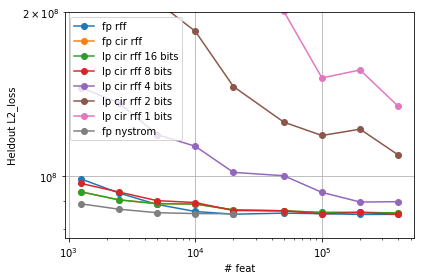

comparing to fp rff [ 98988979.63964503  93235390.00230932  88857922.34958045
  86247377.72925834  85274390.54313071  85643422.34786266
  85462617.00991666  85182899.69015567  85208492.14451687] [   463750    927500   1855000   3710000   7420000  18550000  37100000
  74200000 148400000]
baseline / lp  -1 74200000 51200000.0 85182899.6902 85715133.3248
baseline / lp  8 74200000 26200000.0 85182899.6902 85177635.7598
baseline / lp  -1 74200000 7450000.0 85182899.6902 109513605.948
baseline / lp  -1 74200000 13700000.0 85182899.6902 89895531.8267
baseline / lp  -1 74200000 4325000.0 85182899.6902 134488043.944
lp memory saving  2.8320610687
comparing to cir fp rff
baseline / lp  8 201200000.0 51200000.0 85715135.0519 85715133.3248
baseline / lp  6 201200000.0 6550000.0 85715135.0519 85356747.8325
baseline / lp  -1 201200000.0 7450000.0 85715135.0519 109513605.948
baseline / lp  -1 201200000.0 13700000.0 85715135.0519 89895531.8267
baseline / lp  -1 201200000.0 4325000.0 85715135.0519 1344

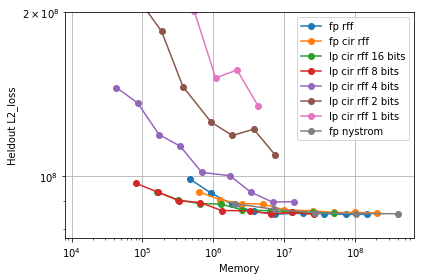

In [7]:
print "census heldout sqrt l2"
m = 250
r = 119
c = 1
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "census_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_0.5_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, 
            do_logy_plot=True, do_logx_plot=True, ylim=[None, 2e8], 
            performance_name="L2_loss", mem_saving_thresh=mem_saving_thresh)

64 [ 86.59020793  84.07858116  82.70401163  81.92943273  81.51448903
  80.74842203  80.61779586  80.56035794  80.52914295]
16 [ 86.5902074   84.07858234  82.70400792  81.92943183  81.51448912
  80.74842196  80.61779626  80.56035762  80.52914337]
8 [ 86.58969327  84.07897352  82.70341154  81.92915462  81.51448916
  80.74820282  80.61779876  80.56020631  80.52919888]
4 [ 86.64405955  84.1239117   82.74104325  81.94493242  81.52965624
  80.75045696  80.61950462  80.55955902  80.5306631 ]
2 [ 87.99454195  85.2429877   83.39883821  82.33949932  81.61880993
  81.1249931   80.83625138  80.58861108  80.54469314]
1 [ 93.83260756  89.83987768  86.90470617  84.73365567  83.09189333
  81.80617154  81.46589563  81.08404163  80.79130001]


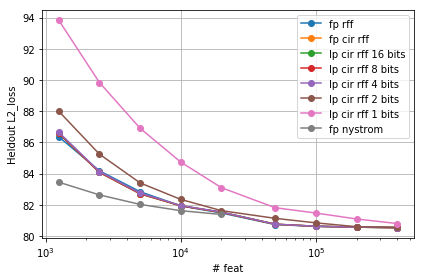

comparing to fp rff [ 86.3576089   84.17319966  82.8345836   81.9256321   81.468077
  80.72597391  80.61099744  80.55769504  80.53403572] [   427500    855000   1710000   3420000   6840000  17100000  34200000
  68400000 136800000]
baseline / lp  8 136800000 51200000.0 80.5340357248 80.5291433739
baseline / lp  8 136800000 26200000.0 80.5340357248 80.5291988808
baseline / lp  -1 136800000 7450000.0 80.5340357248 80.5446931392
baseline / lp  8 136800000 13700000.0 80.5340357248 80.5306630968
baseline / lp  -1 136800000 4325000.0 80.5340357248 80.7913000123
lp memory saving  9.98540145985
comparing to cir fp rff
baseline / lp  8 201200000.0 51200000.0 80.5291429464 80.5291433739
baseline / lp  8 201200000.0 26200000.0 80.5291429464 80.5291988808
baseline / lp  -1 201200000.0 7450000.0 80.5291429464 80.5446931392
baseline / lp  8 201200000.0 13700000.0 80.5291429464 80.5306630968
baseline / lp  -1 201200000.0 4325000.0 80.5291429464 80.7913000123
lp memory saving  14.6861313869
comparing t

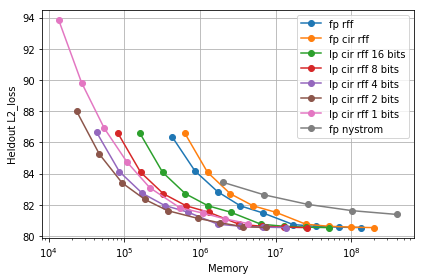

In [8]:
m = 250
r = 90
c = 1
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "yearpred_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_0.5_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, do_logy_plot=False, do_logx_plot=True, 
              performance_name="L2_loss", mem_saving_thresh=mem_saving_thresh)

covtype heldout accuray
64 [ 0.75012729  0.79714292  0.8428677   0.87594931  0.89904119  0.91314014
  0.91826768  0.92003184  0.92197529]
16 [ 0.75012729  0.79714292  0.84294658  0.87594931  0.89903401  0.91314014
  0.91826768  0.92003901  0.92197529]
8 [ 0.75012012  0.79714292  0.84324061  0.876229    0.8995647   0.91285328
  0.91843979  0.9200677   0.92207569]
4 [ 0.7492237   0.79664092  0.84002065  0.8731453   0.89546983  0.91152657
  0.91603021  0.91800951  0.92147329]
2 [ 0.73765625  0.78046944  0.81925948  0.85223353  0.87698916  0.89818779
  0.90542372  0.91355608  0.91778002]
1 [ 0.6918741   0.73255739  0.77415145  0.80660915  0.83612659  0.86214439
  0.88123463  0.89260128  0.90187388]


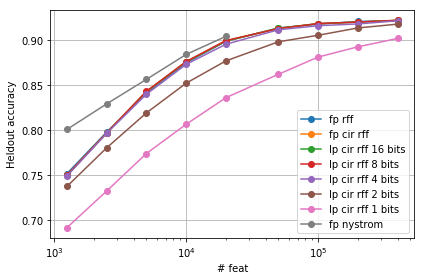

comparing to fp rff [ 0.75188428  0.79794611  0.84137605  0.87478038  0.8986611   0.91357759
  0.91777285  0.92073464  0.92166692] [   383750    767500   1535000   3070000   6140000  15350000  30700000
  61400000 122800000]
baseline / lp  8 122800000 51600000.0 0.921666917665 0.921975287393
baseline / lp  8 122800000 26600000.0 0.921666917665 0.92207568684
baseline / lp  -1 122800000 7850000.0 0.921666917665 0.917780024813
baseline / lp  -1 122800000 14100000.0 0.921666917665 0.921473290162
baseline / lp  -1 122800000 4725000.0 0.921666917665 0.901873883953
lp memory saving  4.61654135338
comparing to cir fp rff
baseline / lp  8 201600000.0 51600000.0 0.921975287393 0.921975287393
baseline / lp  8 201600000.0 26600000.0 0.921975287393 0.92207568684
baseline / lp  -1 201600000.0 7850000.0 0.921975287393 0.917780024813
baseline / lp  -1 201600000.0 14100000.0 0.921975287393 0.921473290162
baseline / lp  -1 201600000.0 4725000.0 0.921975287393 0.901873883953
lp memory saving  7.5789473684

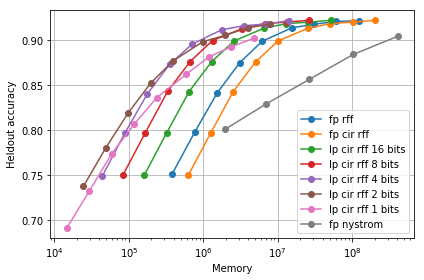

In [9]:
print "covtype heldout accuray"
m = 250
r = 54
c = 2
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "covtype_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_50.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, performance_name="accuracy", mem_saving_thresh=mem_saving_thresh)

covtype heldout cross entropy
64 [ 0.00206956  0.00180625  0.00156841  0.00119275  0.00098343  0.0008423
  0.00078989  0.0007644   0.00075128]
16 [ 0.00206956  0.00180625  0.0015655   0.00119275  0.00098343  0.0008423
  0.00078989  0.0007644   0.00075127]
8 [ 0.00206994  0.00180627  0.00154302  0.00118801  0.00099964  0.00084445
  0.00078915  0.00076442  0.00075053]
4 [ 0.00207242  0.0018117   0.00159936  0.00122609  0.00101725  0.0008694
  0.00081625  0.00078266  0.00075805]
2 [ 0.00212678  0.00189058  0.00170174  0.0014382   0.00121572  0.00105411
  0.00090316  0.00083362  0.00080515]
1 [ 0.00233487  0.00214715  0.00191289  0.00173709  0.00157261  0.00172513
  0.00128494  0.00109429  0.00103184]


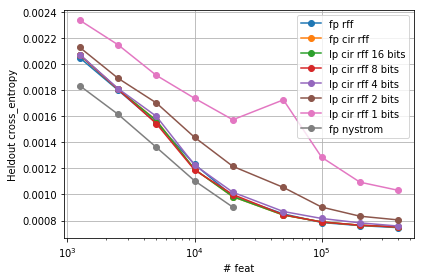

comparing to fp rff [ 0.00204735  0.00179968  0.00154956  0.00123136  0.00098738  0.00085139
  0.00078527  0.0007614   0.00074595] [   383750    767500   1535000   3070000   6140000  15350000  30700000
  61400000 122800000]
baseline / lp  -1 122800000 51600000.0 0.000745954962594 0.000751274809424
baseline / lp  -1 122800000 26600000.0 0.000745954962594 0.000750530376563
baseline / lp  -1 122800000 7850000.0 0.000745954962594 0.00080514512217
baseline / lp  -1 122800000 14100000.0 0.000745954962594 0.000758052078962
baseline / lp  -1 122800000 4725000.0 0.000745954962594 0.00103184088807
lp memory saving  -1
comparing to cir fp rff
baseline / lp  8 201600000.0 51600000.0 0.00075127537359 0.000751274809424
baseline / lp  8 201600000.0 26600000.0 0.00075127537359 0.000750530376563
baseline / lp  -1 201600000.0 7850000.0 0.00075127537359 0.00080514512217
baseline / lp  -1 201600000.0 14100000.0 0.00075127537359 0.000758052078962
baseline / lp  -1 201600000.0 4725000.0 0.00075127537359 0.0

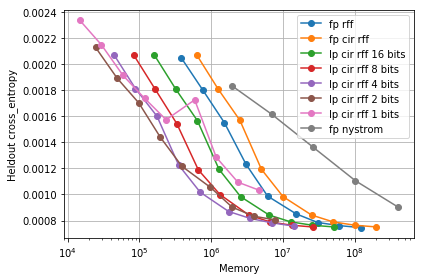

In [13]:
print "covtype heldout cross entropy"
m = 250
r = 54
c = 2
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "covtype_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_50.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3,], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, performance_file_name="monitor_signal.txt",
            do_logy_plot=False, do_logx_plot=True, performance_name="cross_entropy", mem_saving_thresh=mem_saving_thresh)

timit heldout accuracy
64 [ 0.61763014  0.63774672  0.65416247  0.66604941  0.6741594   0.68008995
  0.6830294   0.68383428  0.68461196]
16 [ 0.6175241   0.63775759  0.65414887  0.66607252  0.67414036  0.68027622
  0.68301852  0.68384787  0.67755295]
8 [ 0.61755265  0.63777663  0.6542019   0.66514936  0.67439868  0.68023135
  0.68304163  0.68407085  0.68465955]
4 [ 0.61746427  0.64022798  0.65356425  0.6654947   0.67444083  0.6803306
  0.68317351  0.68412387  0.68517756]
2 [ 0.60705793  0.63101672  0.64755756  0.66072795  0.66920911  0.67834695
  0.68195803  0.68381252  0.68464867]
1 [ 0.56162026  0.59496433  0.61688373  0.63351566  0.64751405  0.6633343
  0.6698386   0.67716954  0.68121434]


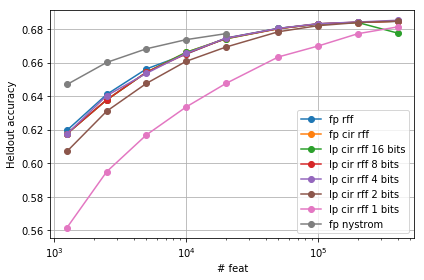

comparing to fp rff [ 0.61960971  0.64100567  0.6562005   0.66498485  0.67458087  0.68036323
  0.68279147  0.68404501  0.68451679] [  1047500   2095000   4190000   8380000  16760000  41900000  83800000
 167600000 335200000]
baseline / lp  -1 335200000 109600000.0 0.684516793041 0.677552946039
baseline / lp  8 335200000 84600000.0 0.684516793041 0.684659550545
baseline / lp  8 335200000 65850000.0 0.684516793041 0.684648673783
baseline / lp  8 335200000 72100000.0 0.684516793041 0.685177556345
baseline / lp  -1 335200000 62725000.0 0.684516793041 0.681214336116
lp memory saving  5.09035687168
comparing to cir fp rff
baseline / lp  -1 259600000.0 109600000.0 0.68461196471 0.677552946039
baseline / lp  8 259600000.0 84600000.0 0.68461196471 0.684659550545
baseline / lp  8 259600000.0 65850000.0 0.68461196471 0.684648673783
baseline / lp  8 259600000.0 72100000.0 0.68461196471 0.685177556345
baseline / lp  -1 259600000.0 62725000.0 0.68461196471 0.681214336116
lp memory saving  3.942293090

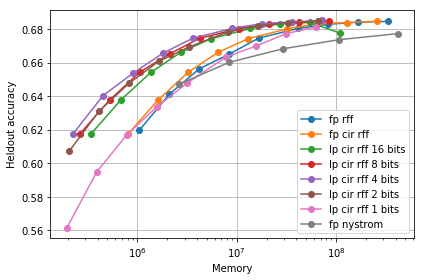

In [14]:
print "timit heldout accuracy"
m = 250
r = 440
c = 147
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "timit_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_100.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func, 
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=False,
            do_logy_plot=False, do_logx_plot=True, performance_name="accuracy", mem_saving_thresh=mem_saving_thresh)

timit heldout cross entropy
64 [ 0.00485218  0.00454319  0.004298    0.00409237  0.00397382  0.00388583
  0.00381943  0.00383031  0.00383367]
16 [ 0.00485493  0.00454318  0.00429801  0.00409233  0.00397379  0.00387572
  0.00381945  0.00383032  0.00394724]
8 [ 0.00485427  0.00454326  0.00429805  0.00412246  0.00396346  0.00387575
  0.00381944  0.0038202   0.00382851]
4 [ 0.00485221  0.00447951  0.00430538  0.00410452  0.00395867  0.00387139
  0.00381259  0.00381419  0.00379411]
2 [ 0.00501159  0.00460746  0.00436044  0.00414289  0.00402606  0.00388107
  0.00381877  0.00379236  0.00379767]
1 [ 0.00580117  0.00519177  0.0048431   0.00456986  0.00434649  0.0040996
  0.00401732  0.00390449  0.00382812]


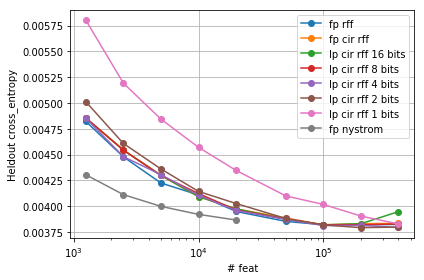

comparing to fp rff [ 0.00482114  0.0044777   0.00422448  0.00410859  0.00394891  0.00385281
  0.00382031  0.00382032  0.00382338] [  1047500   2095000   4190000   8380000  16760000  41900000  83800000
 167600000 335200000]
baseline / lp  6 83800000 27400000.0 0.00382030624861 0.0038194459773
baseline / lp  6 83800000 21150000.0 0.00382030624861 0.00381944461987
baseline / lp  6 83800000 16462500.0 0.00382030624861 0.00381877106498
baseline / lp  6 83800000 18025000.0 0.00382030624861 0.00381258894032
baseline / lp  -1 83800000 62725000.0 0.00382030624861 0.00382812001902
lp memory saving  5.09035687168
comparing to cir fp rff
baseline / lp  6 64900000.0 27400000.0 0.00381943475653 0.0038194459773
baseline / lp  6 64900000.0 21150000.0 0.00381943475653 0.00381944461987
baseline / lp  6 64900000.0 16462500.0 0.00381943475653 0.00381877106498
baseline / lp  6 64900000.0 18025000.0 0.00381943475653 0.00381258894032
baseline / lp  -1 64900000.0 62725000.0 0.00381943475653 0.00382812001902


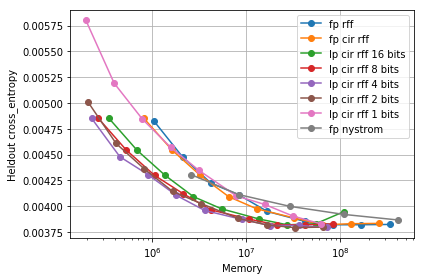

In [12]:
print "timit heldout cross entropy"
m = 250
r = 440
c = 147
rff_mem_func = lambda n : get_rff_memory_with_model(n, m, r, c)
nystrom_mem_func = lambda n : get_nystrom_memory_with_model(n, m, r, c)
cir_rff_mem_func = lambda n, b: get_cir_rff_memory_with_model(n, m, r, b, c)
general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run"
general_folder_metric = "/dfs/scratch0/zjian/lp_kernel/nystrom_vs_rff_large_exp/full_tuning_run_kernel_approx_error"
subfolder_pattern = "timit_type_unk_l2_reg_0_n_fp_feat_unk_opt_sgd_lr_100.0_seed_unk"
nystrom_feat_list = [1250, 2500, 5000, 10000, 20000]
rff_feat_list = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
plot_full_run(rff_feat_list, nystrom_feat_list, general_folder_performance, general_folder_metric, subfolder_pattern, seeds=[1,2,3], 
            rff_mem_func=rff_mem_func, nystrom_mem_func=nystrom_mem_func,
            cir_rff_mem_func=cir_rff_mem_func, min_metric_best=True, performance_file_name="monitor_signal.txt",
            do_logy_plot=False, do_logx_plot=True, performance_name="cross_entropy", mem_saving_thresh=mem_saving_thresh)